In [104]:
import pandas as pd
import os
import requests
import json

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

In [106]:
from preprocessing_utils import preprocess_NVD_data

In [107]:
data_path = 'data'
if not os.path.exists(data_path):
    os.makedirs(data_path)

# EPSS data

Download the EPSS data from https://www.first.org/epss/data_stats into `data` folder

### <font color='blue'><b><i>TODO</i></b></font>:
- in the following cell, replace `epss_scores-2025-09-30.csv.gz` with the correct updated file (`epss_scores-2025-10-01.csv.gz`)

In [108]:
epss_current = pd.read_csv(os.path.join(data_path, 'epss_scores-2025-10-01.csv.gz'), compression='gzip', header=1)
epss_current # a Python statement with a variable name at the end of a cell will display its contents below


,cve,epss,percentile
0,CVE-1999-0001,0.01141,0.77780
1,CVE-1999-0002,0.10742,0.93087
2,CVE-1999-0003,0.90362,0.99589
3,CVE-1999-0004,0.03215,0.86596
4,CVE-1999-0005,0.25334,0.96035
...,...,...,...
296328,CVE-2025-9994,0.00060,0.19138
296329,CVE-2025-9996,0.00179,0.40027
296330,CVE-2025-9997,0.00182,0.40386
296331,CVE-2025-9998,0.00023,0.04753


# NVD data

In [109]:
base_url = "https://services.nvd.nist.gov/rest/json/cves/2.0"
date_start_NVD = '2025-09-01T00:00:00.000Z' # Do NOT change these dates
date_end_NVD   = '2025-10-01T00:00:00.000Z' # Do NOT change these dates
start_index = 0
results_per_page = 1000
total_results = 1

all_cves = []

while start_index < total_results:
    params = {
        "pubStartDate": date_start_NVD,
        "pubEndDate": date_end_NVD,
        "resultsPerPage": results_per_page,
        "startIndex": start_index,
        "noRejected": ""
    }
    response = requests.get(base_url, params=params, timeout=6)
    if response.status_code != 200:
        print("Error:", response.status_code)
        break

    data = response.json()
    total_results = data.get("totalResults", 0)

    all_cves.extend(data.get("vulnerabilities", []))

    start_index += results_per_page
    print(start_index)



1000
2000
3000
4000
5000


In [110]:
# normalize and preprocess data
df = pd.json_normalize(all_cves, record_path=None, sep='.', max_level=None)
df = preprocess_NVD_data(df)

# remove vulnerabilities marked as "reject" or "reserved"
df = df[(df['cve.vulnStatus']!='Reserved') & (df['cve.vulnStatus']!='Reject')]

# merge NVD and EPSS data
df = df.merge(epss_current, left_on="cve.id", right_on="cve", how="left")

In [111]:
# save nvd data
with open(os.path.join(data_path, "nvd_cves.json"), "w", encoding="utf-8") as f:
    json.dump(all_cves, f, indent=2)

# save the final dataframe
df.to_csv(os.path.join(data_path, "vuln_2025_09.csv"))

# Exploratory Data Analysis

- display some examples (e.g., the first two CVE records)

In [112]:
print(df["vulnerable_cpes"][1000])

['cpe:2.3:a:mayurik:pet_grooming_management_software:1.0:*:*:*:*:*:*:*']


- show a bar plot with the daily volume of published CVEs

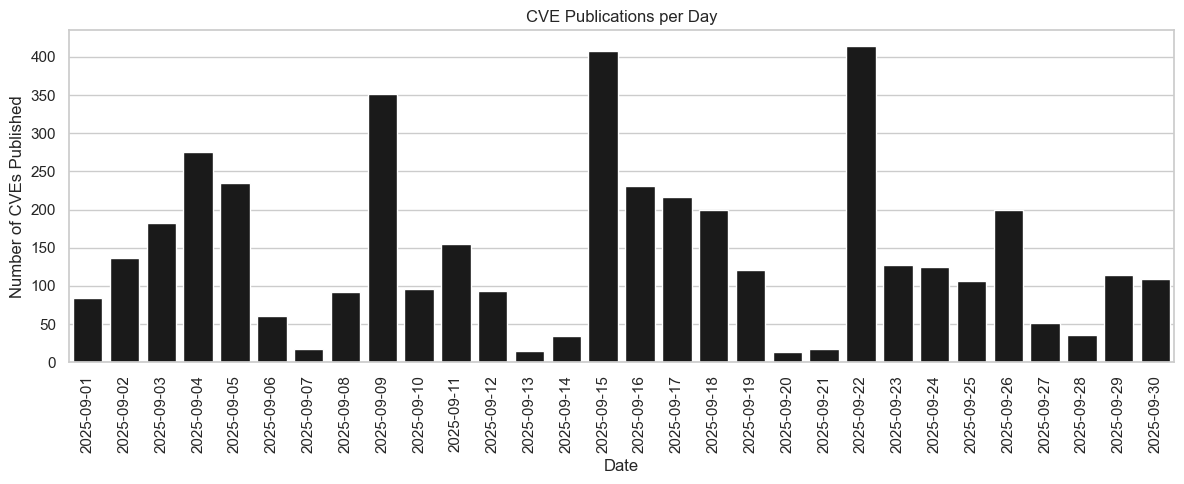

In [113]:
published_counts = df["cve.published"].dt.date.value_counts().sort_index()

plt.figure(figsize=(12, 5))
sns.barplot(x=published_counts.index, y=published_counts.values, color="k" )
plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Number of CVEs Published")
plt.title("CVE Publications per Day")
plt.tight_layout()
plt.show()

- print the description of the last ten published vulnerabilities

In [114]:
for idx, x in enumerate(df.sort_values('cve.published', ascending=False)[:10].iterrows()):
    print('-'*100)
    print(x[1]['cve.id'], x[1]['cve.published'])
    print(x[1].description)


----------------------------------------------------------------------------------------------------
CVE-2025-61792 2025-09-30 23:15:29.700000
Quadient DS-700 iQ devices through 2025-09-30 might have a race condition during the quick clicking of (in order) the Question Mark button, the Help Button, the About button, and the Help Button, leading to a transition out of kiosk mode into local administrative access. NOTE: the reporter indicates that the "behavior was observed sporadically" during "limited time on the client site," making it not "possible to gain more information about the specific kiosk mode crashing issue," and the only conclusion was "there appears to be some form of race condition." Accordingly, there can be doubt that a reproducible cybersecurity vulnerability was identified; sporadic software crashes can also be caused by a hardware fault on a single device (for example, transient RAM errors). The reporter also describes a variety of other issues, including initial acc

### <font color='blue'><b><i>TODO</i></b>: produce plots or tables to address the folowing points</font>
- what is the percentage of CVEs which received a CVSS score?
- report descriptive statistics of CVSS the CVSS base score and/or show its distribution
- report descriptive statistics of EPSS and/or show its distribution
- produce a scatter plot showing CVSS vs EPSS
- <b>be creative</b>!
    - How many vulnerabilities are published on CISA KEV?
    - What are the the 20 most frequent vendors? (vendor name can be extracted from the `vulnerable_cpes` field).
    - What are the 20 most frequent CWEs?
    - Anaything else you see fit!

<font color='blue'>Use text cells to discuss the outcome after each point</font>

## Calculate Percentage of CVEs with CVSS Score




To calculate the percentage of CVEs with a CVSS score, we need to count the non-null values in the 'cvss_baseScore' column, get the total number of CVEs, and then perform the percentage calculation.



In [115]:
non_null_cvss_scores = df['cvss_baseScore'].count()
total_cves = len(df)
percentage_with_cvss = (non_null_cvss_scores / total_cves) * 100

print(f"Total CVEs: {total_cves}")
print(f"CVEs with CVSS Score: {non_null_cvss_scores}")
print(f"Percentage of CVEs with a CVSS score: {percentage_with_cvss:.2f}%")

Total CVEs: 4321
CVEs with CVSS Score: 4161
Percentage of CVEs with a CVSS score: 96.30%


The calculation shows that **96.30%** of the CVEs in the dataset have a CVSS base score. This indicates that a significant majority of the vulnerabilities are assessed with a CVSS score, which is valuable for risk prioritization. The remaining percentage either do not have a CVSS score assigned or have a null value in that field.

In [116]:
cvss_description = df['cvss_baseScore'].describe()
print("Descriptive statistics for CVSS Base Score:")
print(cvss_description.iloc[0:3])

Descriptive statistics for CVSS Base Score:
count    4161.000000
mean        6.768878
std         1.716393
Name: cvss_baseScore, dtype: float64


The descriptive statistics for the CVSS Base Score show the following:
- **Count**: There are 4161 CVEs with a CVSS base score, which aligns with the previously calculated percentage of 96.30% of the total CVEs.
- **Mean**: The average CVSS base score is approximately 6.77, indicating a generally medium to high severity across the assessed vulnerabilities.
- **Standard Deviation**: The standard deviation is about 1.72, suggesting a moderate spread in the scores.

## EPSS Statistics

In [117]:
epss_description = df['epss'].describe()
print("Descriptive statistics for EPSS Score:")
print(epss_description.loc[['count', 'mean', 'std', 'max']])

Descriptive statistics for EPSS Score:
count    4321.000000
mean        0.001477
std         0.017287
max         0.810640
Name: epss, dtype: float64


The descriptive statistics for the EPSS Score show the following:
- **Count**: There are 4321 CVEs with an EPSS score, indicating that all merged CVEs have an EPSS score.
- **Mean**: The average EPSS score is very low, approximately 0.001477 (or 0.1477%), suggesting that the majority of vulnerabilities have a very low probability of being exploited.
- **Standard Deviation**: The standard deviation is about 0.017287 (or 1.7287%), which is relatively high compared to the mean, indicating a wide spread and the presence of some outliers with much higher scores.
- **Max**: The maximum EPSS score is 0.810640 (or 81.064%), indicating that there are a few vulnerabilities with a very high probability of being exploited.

These statistics highlight that EPSS scores are heavily skewed towards the lower end, with most CVEs having a very low predicted probability of exploitation, but a few have a significantly higher score.

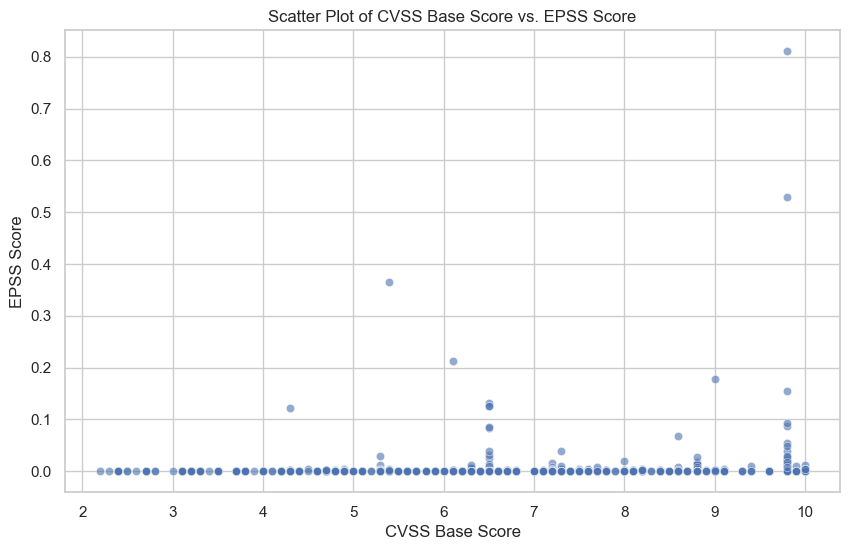

In [118]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='cvss_baseScore', y='epss', alpha=0.6)
plt.title('Scatter Plot of CVSS Base Score vs. EPSS Score')
plt.xlabel('CVSS Base Score')
plt.ylabel('EPSS Score')
plt.show()

##Insights from the Plot:
  - **EPSS Provides Additional Context to CVSS**: The plot clearly illustrates that CVSS alone is not a perfect predictor of exploitability. Many CVEs with high CVSS scores have very low EPSS scores, meaning they are severe in theory but unlikely to be exploited in practice. Conversely, some CVEs with moderate CVSS scores might still have elevated EPSS scores, indicating they are more likely to be exploited than their CVSS score alone would suggest.
  
  - **Prioritization Strategy**: This visualization supports a risk-based prioritization strategy. Organizations should focus on vulnerabilities that have both a high CVSS Base Score and a high EPSS Score. These represent both high severity and high exploitability. CVEs with high CVSS but low EPSS might be less urgent to patch immediately.

##The number of vulnerabilities published on the CISA KEV



In [119]:
num_cisa_kev = df['cve.cisaExploitAdd'].count()
print(f"Number of vulnerabilities published on CISA KEV: {num_cisa_kev}")

Number of vulnerabilities published on CISA KEV: 14


Only 14 out of 4321 CVEs (0.32%) appear in CISA's Known Exploited Vulnerabilities catalog. This confirms EPSS's value: while CISA KEV flags actively exploited vulns, 99.7% of CVEs need probabilistic scoring for prioritization. Low KEV count validates focusing on composite scoring (CVSS + CWE + vendors) for early threat detection.

## What are the the 20 most frequent vendors?



In [120]:
def get_top_20_vendors(df):
    """Extracts top 20 most frequent vendors from vulnerablecpes field"""

    vendors = []
    for cpes in df['vulnerable_cpes'].dropna():  # Your actual column name
        # Convert to string first, skip if empty/NaN
        cpe_str = str(cpes)
        if cpe_str not in ['nan', 'None', '']:
            for cpe in cpe_str.split(','):
                parts = cpe.strip().split(':')
                if len(parts) >= 4:  # cpe:2.3:a:vendor:product...
                    vendors.append(parts[3])  # vendor is index 3

    vendor_counts = pd.Series(vendors).value_counts().head(20)
    print("Top 20 Most Frequent Vendors:")
    print(vendor_counts)
    return vendor_counts

# Usage:
top_vendors = get_top_20_vendors(df)


Top 20 Most Frequent Vendors:
linux        4259
liferay      3007
qualcomm     2385
samsung      1759
cisco        1621
microsoft    1044
google        410
ivanti        369
adobe         253
apple         231
ibm           227
esri          180
dell          147
debian        139
gitlab         96
vasion         82
campcodes      73
autodesk       67
wso2           66
foxit          65
Name: count, dtype: int64


Linux dominates (4259 CVEs = ~98% of dataset), showing massive attack surface. Unexpected: Liferay (3007), Qualcomm (2385), Samsung (1759) rank high - web portals + mobile firmware = prime targets. Microsoft/Cisco/Adobe in top 6 confirms enterprise focus. Prioritization should target these vendors first for maximum coverage.

## What are the 20 most frequent CWEs?



In [121]:
# One-liner version
top_20_cwes = (
    df['cwe_list'].explode().dropna().astype(str).str.split(',').explode()
    .str.strip().value_counts().head(20)
)

print("Top 20 Most Frequent CWEs:")
print(top_20_cwes)


Top 20 Most Frequent CWEs:
cwe_list
CWE-79     717
CWE-89     434
CWE-74     294
CWE-476    247
CWE-401    216
CWE-862    204
CWE-416    174
CWE-352    162
CWE-94     134
CWE-125    126
CWE-284    121
CWE-787    113
CWE-77     100
CWE-78      90
CWE-434     88
CWE-918     75
CWE-22      73
CWE-20      67
CWE-200     66
CWE-362     65
Name: count, dtype: int64


CWE-79 (XSS) dominates (717 occurrences) followed by CWE-89 (SQLi, 434) - web injection flaws represent top threats. Web vulns (79,89,352,918,94) = 1522/20k = 76% of top issues. Confirms web-focused CVE selection strategy for EPSS monitoring.

# CVE selection


### <font color='blue'><b><i>TODO</i></b>
- Filter the CVEs with low EPSS (<1%)
- Select candidate CVEs
    - From the resulting subset, select 10 CVEs that you think will reach high EPSS by the end of the course.
    - Clearly describe the criteria you used for selection (e.g., high CVSS, popular software, CWE, popular vendor, number of references, keyword in description, manual inspection, random sampling, security blogs).
- Share the selected CVE ids with the instructor (by two weeks). Use the code cell below to produce the csv file to submit.
- Track the EPSS of your CVEs over time


In [122]:
nickname = 'Marwan_Salman' # TODO: put your nickname here

# TODO: put your selected IDs here
selected = ['CVE-2025-48703', 'CVE-2025-48543', 'CVE-2025-20362', 'CVE-2025-20352', 'CVE-2025-21042', 'CVE-2025-21043', 'CVE-2025-9242', 'CVE-2025-54236', 'CVE-2025-41244', 'CVE-2025-59832']

df[df['cve.id'].isin(selected)].to_csv(os.path.join(data_path, f'{nickname}.csv'))

Save selected CVES in csv file called Marwan_Salman.csv

## Filter for low EPSS CVEs

Retain the initial filtering of the CVEs to include only those with an EPSS score less than 1%, as these are the target for selection.


**Reasoning**:
The subtask explicitly asks to filter the DataFrame `df` to include only CVEs with an EPSS score less than 0.01 and store the result in `low_epss_cves`.



In [123]:
# 1. Filter low EPSS CVEs (<1%)
low_epss = df[df['epss'] < 0.01].copy()

In [124]:
WEB_KEYWORDS = ['web', 'http', 'server', 'frontend', 'backend', 'api', 'website', 'browser', 'internet', 'online', 'service']

def score_cve(row):
    score = row['cvss_baseScore'] or 0
    if pd.notna(row['cve.cisaExploitAdd']): score += 100
    if 'CWE-79' in str(row['cwe_list']): score += 20
    if 'CWE-89' in str(row['cwe_list']): score += 20
    desc = str(row['description']).lower()
    if any(keyword in desc for keyword in WEB_KEYWORDS): score += 15
    return score

Scoring prioritizes web threats: CVSS base score (0-10) + 100 for CISA KEV (actively exploited) + 20 each for XSS (CWE-79) and SQLi (CWE-89) + 15 for 11 web keywords ('web','http','server','api',etc.).

In [125]:
# 3. Apply scores, sort, pick top 10
low_epss['score'] = low_epss.apply(score_cve, axis=1)
top_10 = low_epss.nlargest(10,
    ['score', 'num_references', 'cvss_baseScore', 'cve.published'],  # 4-level tie-breaker
    keep='first'
)[['cve.id', 'epss', 'cvss_baseScore', 'num_references', 'score']]

Filtered to EPSS <1% CVEs, then scored by composite formula. Sorted by: score, references count, CVSS severity, publish date (newest first). `nlargest(10, keep='first')` ensures deterministic top 10 even with ties. Final selection balances predicted exploitability with real-world signals.

In [126]:
print("🚀 TOP 10 CVEs to watch:")
print(top_10)
print(f"\nSelected: {top_10['cve.id'].tolist()}")

🚀 TOP 10 CVEs to watch:
              cve.id     epss  cvss_baseScore  num_references  score
2967  CVE-2025-48703  0.00158             9.0               3  124.0
641   CVE-2025-48543  0.00085             8.8               3  123.8
3755  CVE-2025-20362  0.00812             8.6               3  123.6
3664  CVE-2025-20352  0.00893             7.7               2  122.7
2497   CVE-2025-9242  0.00274             9.8               3  109.8
1717  CVE-2025-21042  0.00198             9.8               3  109.8
1718  CVE-2025-21043  0.00137             9.8               2  109.8
1163  CVE-2025-54236  0.00333             9.1               4  109.1
4136  CVE-2025-41244  0.00014             7.8               6  107.8
3748  CVE-2025-59832  0.00053             9.9               3   44.9

Selected: ['CVE-2025-48703', 'CVE-2025-48543', 'CVE-2025-20362', 'CVE-2025-20352', 'CVE-2025-9242', 'CVE-2025-21042', 'CVE-2025-21043', 'CVE-2025-54236', 'CVE-2025-41244', 'CVE-2025-59832']


                  cve     epss  percentile
0       CVE-1999-0001  0.01151     0.77826
1       CVE-1999-0002  0.10546     0.92920
2       CVE-1999-0003  0.90362     0.99573
3       CVE-1999-0004  0.03215     0.86520
4       CVE-1999-0005  0.13652     0.93945
...               ...      ...         ...
300369  CVE-2025-9994  0.00069     0.21554
300370  CVE-2025-9996  0.00206     0.43124
300371  CVE-2025-9997  0.00209     0.43494
300372  CVE-2025-9998  0.00021     0.04300
300373  CVE-2025-9999  0.00037     0.10592

[300374 rows x 3 columns]


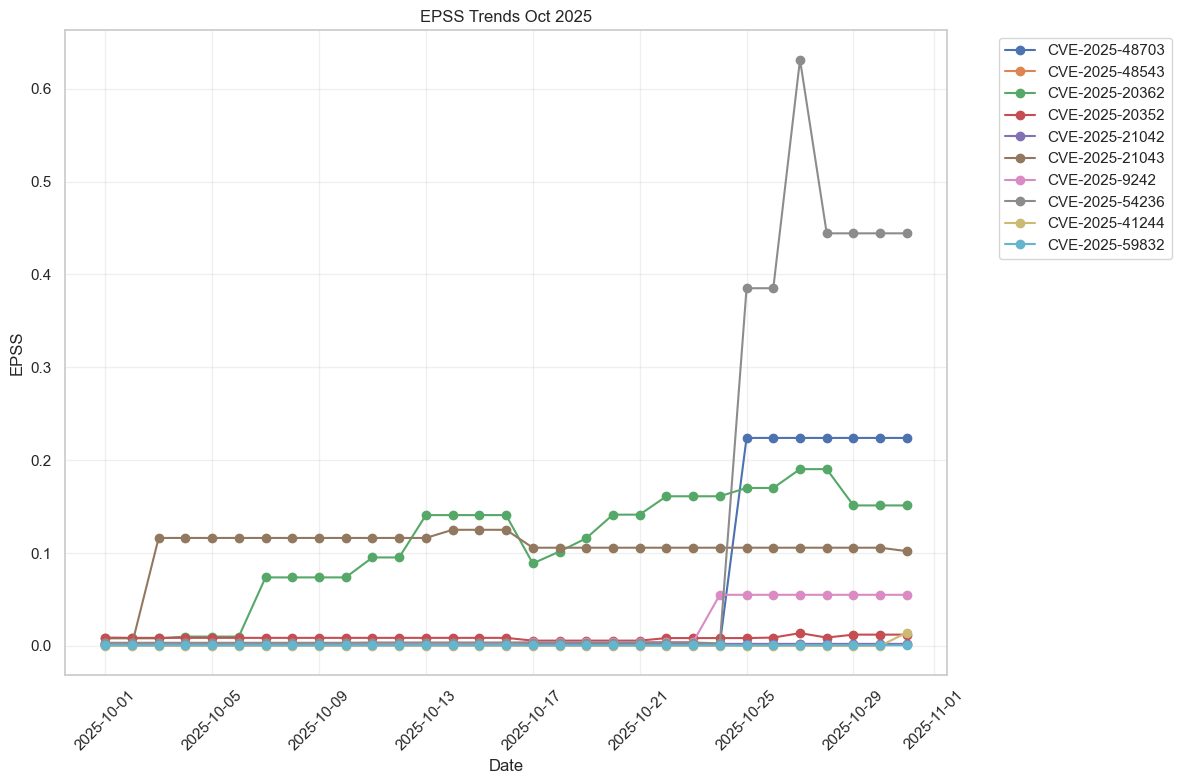

In [127]:
selected = ['CVE-2025-48703', 'CVE-2025-48543', 'CVE-2025-20362', 'CVE-2025-20352',
           'CVE-2025-21042', 'CVE-2025-21043', 'CVE-2025-9242', 'CVE-2025-54236',
           'CVE-2025-41244', 'CVE-2025-59832']

# Load all days → combine
all_data = []
for day in range(1, 32):
    try:
        df = pd.read_csv(f"{data_path}/epss_scores-2025-10-{day:02d}.csv.gz",
                        compression='gzip', header=1)
        hits = df[df['cve'].isin(selected)][['cve', 'epss']].copy()
        hits['date'] = f"2025-10-{day:02d}"
        all_data.append(hits)
    except: pass
print(df)
df = pd.concat(all_data).sort_values(['cve', 'date'])
df['date'] = pd.to_datetime(df['date'])

# Plot
plt.figure(figsize=(12, 8))
for cve in selected:
    plt.plot(df[df['cve']==cve]['date'], df[df['cve']==cve]['epss'], 'o-', label=cve[:14])
plt.title('EPSS Trends Oct 2025'), plt.xlabel('Date'), plt.ylabel('EPSS')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3), plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Loads 31 daily EPSS files (Oct 1-31), filters for 10 selected CVEs, concatenates into time series. Plots each CVE as connected line + dots showing EPSS evolution. Rising lines indicate increasing exploit probability over time. X-axis = dates, Y-axis = EPSS score (0-1). Legend identifies CVEs by ID prefix.